In [1]:
import pandas as pd
import numpy as np
import os

from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import balanced_accuracy_score

from sklearn.model_selection import KFold
from sklearn.metrics import recall_score

---
---
Leemos datos

In [2]:
ruta = '/content/drive/MyDrive/TFM/TFM/LiqDB/Data/LiqDBDataSetSinOutliers.csv'
dataset = pd.read_csv(ruta, sep="\t")

# Elección de columnas mediante correlación

In [3]:
# Normalizamos las características dentro del rango [0,1]
min_max_scaler = preprocessing.MinMaxScaler()

# Quitamos la columna de ID
columnas = dataset.columns.tolist()
columnas.remove(columnas[0])

features_norm = min_max_scaler.fit_transform(dataset[columnas])

dataset_norm = pd.DataFrame(features_norm, columns=columnas)


correlation_matrix = dataset_norm.corr()
relevant_columns = correlation_matrix[abs(correlation_matrix['Cancer']) > 0.2].index
dataset_norm = dataset_norm[relevant_columns]

X = dataset_norm.drop(columns=['Cancer'])  # Variables predictoras
y = dataset_norm['Cancer']  # Variable objetivo

In [4]:
#definimos funcion para mostrar los resultados
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix

LABELS = ["Healthy","Disease"]

def mostrar_resultados(y_test, pred_y):
    conf_matrix = confusion_matrix(y_test, pred_y)
    plt.figure(figsize=(9, 9))
    sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()

def medidas(cm):
  VP = cm[1][1]
  FP = cm[0][1]
  VN = cm[0][0]
  FN = cm[1][0]
  print("Precision:",round(VP/(VP+FP)*100,2))
  print("Especificidad:",round(VN/(VN+FP)*100,2))
  print("Exactitud:",round((VP+VN)/(VP+VN+FP+FN)*100,2))
  print("Sensibilidad:",round(VP/(VP+FN)*100,2))
  print("Error tipo I:",round(FP/(VN+FP)*100,2))
  print("Error tipo II:",round(FN/(VP+FN)*100,2))

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

In [6]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

# Regresión logística

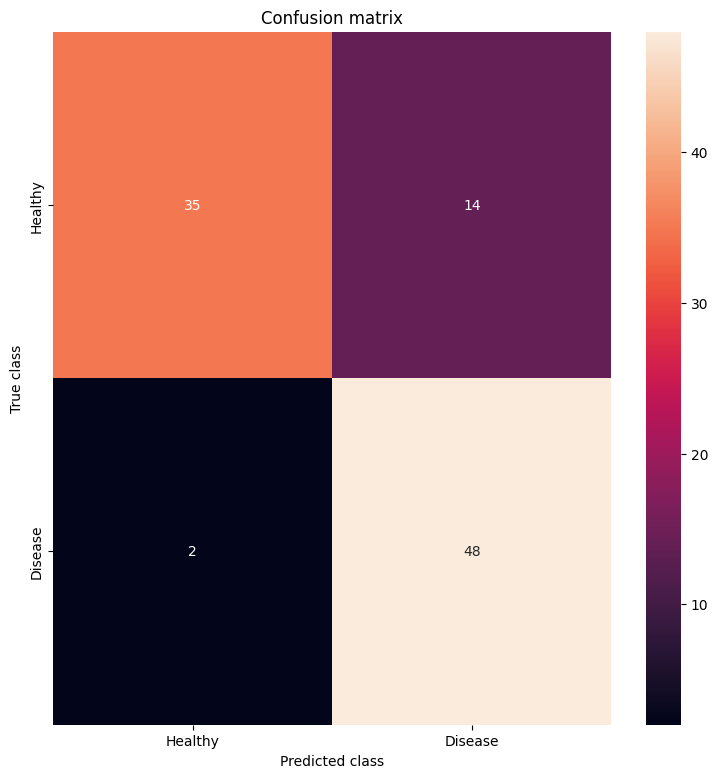

Precision: 77.42
Especificidad: 71.43
Exactitud: 83.84
Sensibilidad: 96.0
Error tipo I: 28.57
Error tipo II: 4.0


In [7]:
# Inicializar y entrenar el modelo de regresión logística
model = LogisticRegression()
model.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred = model.predict(X_test)

# Calcular la precisión del modelo
mostrar_resultados(y_test, y_pred)

# Mostrar medidas
cm = confusion_matrix(y_test, y_pred)
medidas(cm)

## Random Search

In [8]:
param_dist = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Parámetro de regularización
    'penalty': ['l2', None],  # Tipo de penalización
    'solver': ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag'],  # Algoritmo de optimización
}

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 48 is smaller than n_iter=100. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


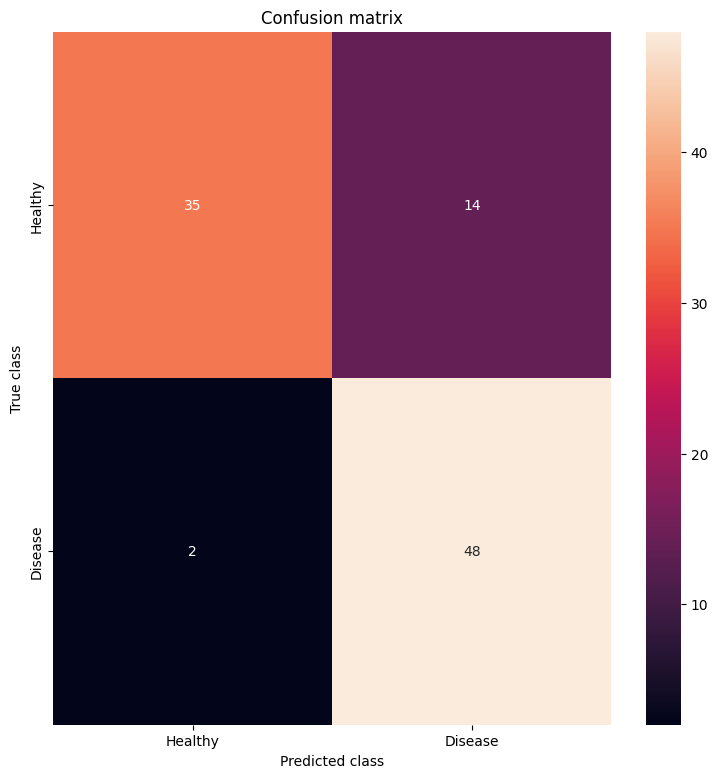

Precision: 77.42
Especificidad: 71.43
Exactitud: 83.84
Sensibilidad: 96.0
Error tipo I: 28.57
Error tipo II: 4.0


In [9]:
# Inicializar y entrenar el modelo de regresión logística
model = LogisticRegression()

# Realizar la búsqueda aleatoria de hiperparámetros
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, scoring=make_scorer(balanced_accuracy_score),
                                   n_iter=100, cv=5, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

# Obtener el mejor modelo
best_model = random_search.best_estimator_

# Predecir en el conjunto de prueba
y_pred = best_model.predict(X_test)

# Calcular la precisión del modelo
mostrar_resultados(y_test, y_pred)

# Mostrar medidas
cm = confusion_matrix(y_test, y_pred)
medidas(cm)

In [10]:
report(random_search.cv_results_, n_top = 3)

Model with rank: 1
Mean validation score: 0.869 (std: 0.044)
Parameters: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 1}

Model with rank: 1
Mean validation score: 0.869 (std: 0.044)
Parameters: {'solver': 'newton-cg', 'penalty': 'l2', 'C': 1}

Model with rank: 1
Mean validation score: 0.869 (std: 0.044)
Parameters: {'solver': 'newton-cholesky', 'penalty': 'l2', 'C': 1}

Model with rank: 1
Mean validation score: 0.869 (std: 0.044)
Parameters: {'solver': 'sag', 'penalty': 'l2', 'C': 1}



# Modelo KNN

### Modelo KNN sobre los datos balanceados

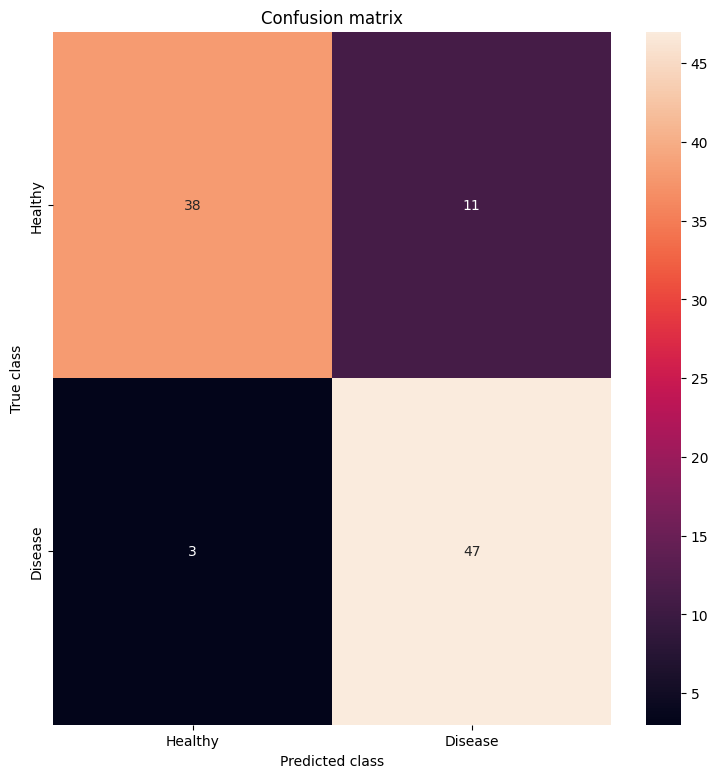

Precision: 81.03
Especificidad: 77.55
Exactitud: 85.86
Sensibilidad: 94.0
Error tipo I: 22.45
Error tipo II: 6.0


In [11]:
# Inicializar el clasificador k-NN
knn = KNeighborsClassifier(n_neighbors=5, weights = 'distance')

# Entrenar el modelo
knn.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = knn.predict(X_test)

# Calcular la precisión del modelo
mostrar_resultados(y_test, y_pred)

# Mostrar medidas
cm = confusion_matrix(y_test, y_pred)
medidas(cm)

## Random Search

In [12]:
param_dist = {
    'n_neighbors': sp_randint(1, 20),  # Número de vecinos
    'weights': ['uniform', 'distance'],  # Método de asignación de pesos
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # Algoritmo para calcular los vecinos
    'leaf_size': sp_randint(10, 50),  # Tamaño de la hoja para algoritmos de árbol
    'p': [1, 2]  # Parámetro de potencia para la métrica Minkowski
}

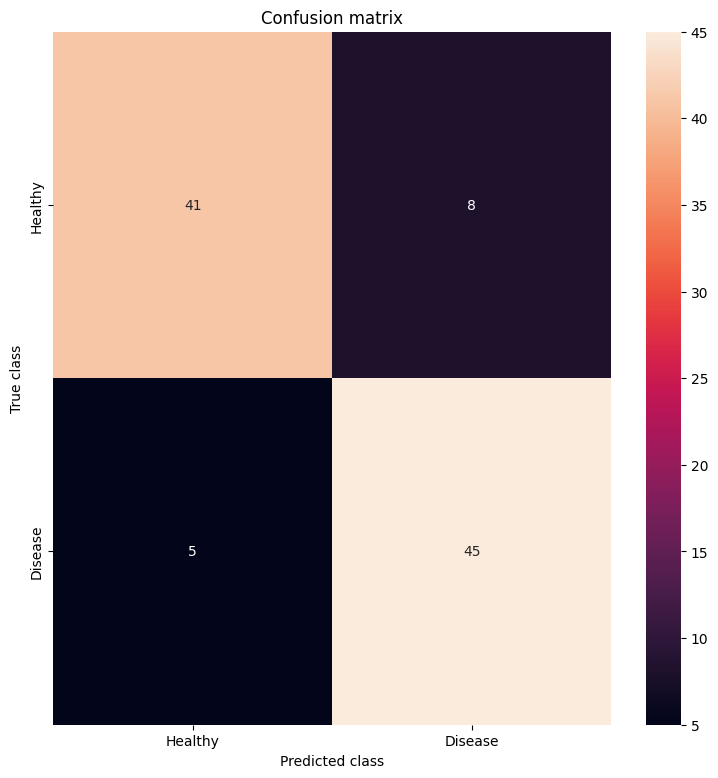

Precision: 84.91
Especificidad: 83.67
Exactitud: 86.87
Sensibilidad: 90.0
Error tipo I: 16.33
Error tipo II: 10.0


In [13]:
# Inicializar el clasificador k-NN
knn = KNeighborsClassifier()

# Realizar la búsqueda aleatoria de hiperparámetros
random_search = RandomizedSearchCV(estimator=knn, param_distributions=param_dist, scoring=make_scorer(balanced_accuracy_score),
                                   n_iter=100, cv=5, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

# Obtener el mejor modelo
best_model = random_search.best_estimator_

# Realizar predicciones en el conjunto de prueba
y_pred = best_model.predict(X_test)

# Calcular la precisión del modelo
mostrar_resultados(y_test, y_pred)

# Mostrar medidas
cm = confusion_matrix(y_test, y_pred)
medidas(cm)

# Modelo Árbol de Decisión

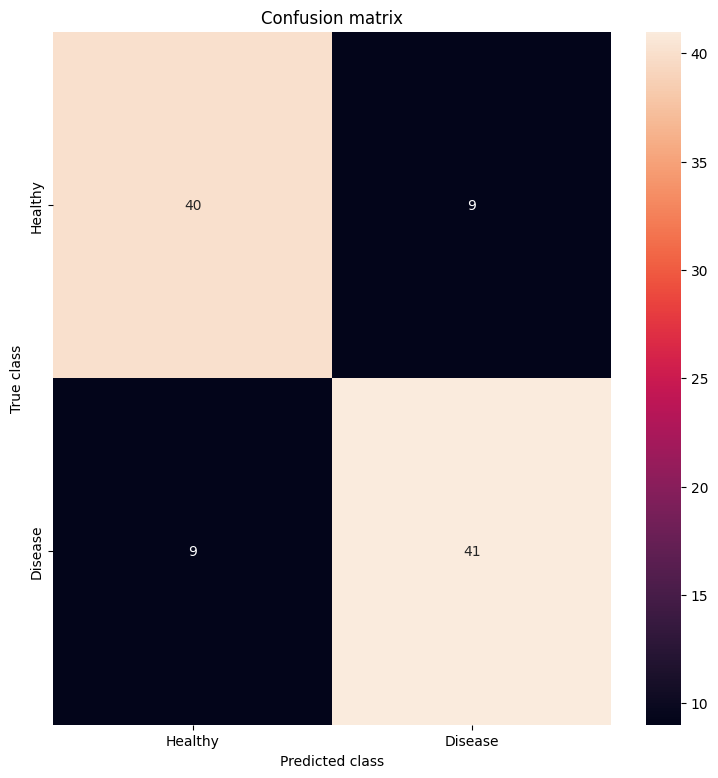

Precision: 82.0
Especificidad: 81.63
Exactitud: 81.82
Sensibilidad: 82.0
Error tipo I: 18.37
Error tipo II: 18.0


In [14]:
# Inicializar el clasificador de árbol de decisión
dt_classifier = DecisionTreeClassifier(max_depth=10, random_state=42)

# Entrenar el modelo
dt_classifier.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = dt_classifier.predict(X_test)

# Calcular la precisión del modelo
mostrar_resultados(y_test, y_pred)

# Mostrar medidas
cm = confusion_matrix(y_test, y_pred)
medidas(cm)

## Random Search

In [15]:
param_dist = {
    'criterion': ['gini', 'entropy'],  # Criterio de calidad de la partición
    'splitter': ['best', 'random'],  # Estrategia para elegir la división en cada nodo
    'max_depth': [None] + list(sp_randint(1, 20).rvs(10)),  # Profundidad máxima del árbol
    'min_samples_split': sp_randint(2, 20),  # Número mínimo de muestras requeridas para dividir un nodo interno
    'min_samples_leaf': sp_randint(1, 20),  # Número mínimo de muestras requeridas para ser una hoja
    'max_features': ['auto', 'sqrt', 'log2', None],  # Número máximo de características a considerar en cada división
    'ccp_alpha': np.linspace(0.0, 0.5, 10)  # Parámetro de complejidad de coste mínimo
}

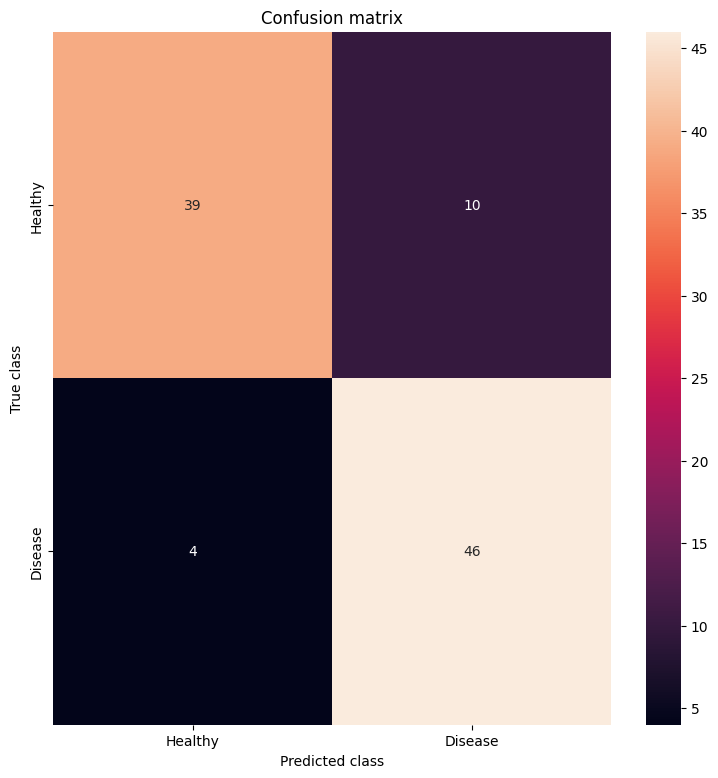

Precision: 82.14
Especificidad: 79.59
Exactitud: 85.86
Sensibilidad: 92.0
Error tipo I: 20.41
Error tipo II: 8.0


In [16]:
# Inicializar el clasificador de árbol de decisión
dt_classifier = DecisionTreeClassifier()

# Realizar la búsqueda aleatoria de hiperparámetros
random_search = RandomizedSearchCV(estimator=dt_classifier, param_distributions=param_dist, scoring=make_scorer(balanced_accuracy_score),
                                   n_iter=100, cv=5, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

# Obtener el mejor modelo
best_model = random_search.best_estimator_

# Realizar predicciones en el conjunto de prueba
y_pred = best_model.predict(X_test)

# Calcular la precisión del modelo
mostrar_resultados(y_test, y_pred)

# Mostrar medidas
cm = confusion_matrix(y_test, y_pred)
medidas(cm)

# Modelo Bosque de Aleatorio

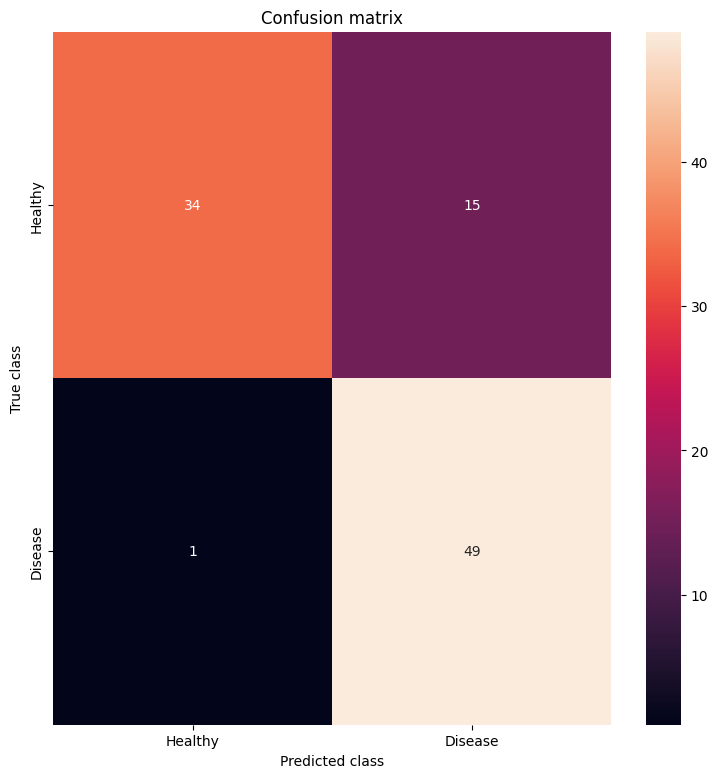

Precision: 76.56
Especificidad: 69.39
Exactitud: 83.84
Sensibilidad: 98.0
Error tipo I: 30.61
Error tipo II: 2.0


In [17]:
# Inicializar el clasificador de bosque aleatorio
rf_regressor  = RandomForestClassifier(max_depth=10, random_state=42)

# Entrenar el modelo
rf_regressor.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = rf_regressor .predict(X_test)

# Calcular la precisión del modelo
mostrar_resultados(y_test, y_pred)

# Mostrar medidas
cm = confusion_matrix(y_test, y_pred)
medidas(cm)

## Random Search

In [18]:
param_dist = {"n_estimators": [8, 16, 32], # Número de árboles en el bosque aleatorio
              "max_features": ['auto', 'sqrt'], # Número de características a considerar en cada división
              "max_depth": [12, 8, 4], # Número máximo de niveles en el árbol
              "min_samples_split": sp_randint(2, 10), # Número mínimo de muestras requeridas para dividir un nodo
              "min_samples_leaf": sp_randint(1, 10), # Número mínimo de muestras requeridas en cada nodo hoja
              "bootstrap": [True, False], # Método de selección de muestras para entrenar cada árbol
              "criterion": ['log_loss', 'entropy', 'gini']} # Criterio de evaluación de la calidad de una división

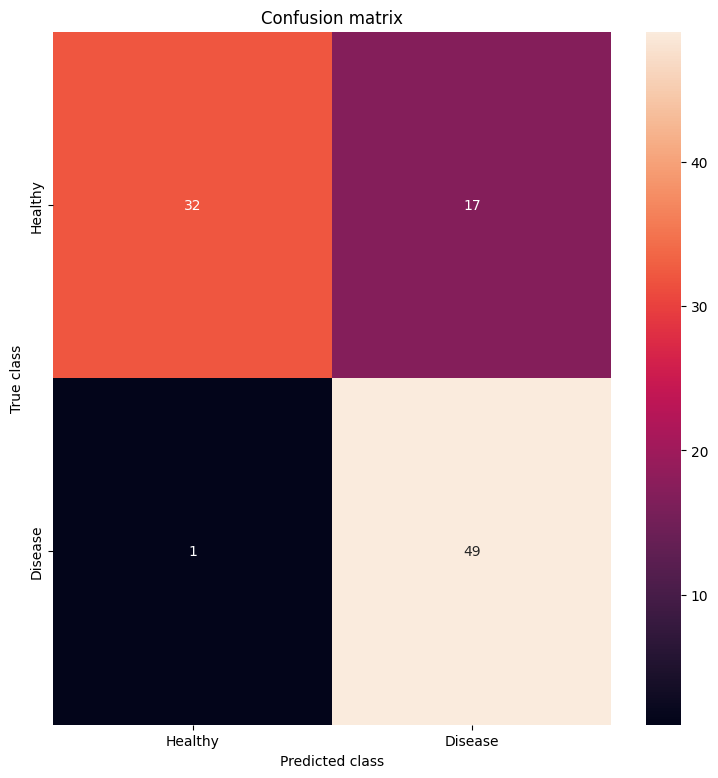

Precision: 74.24
Especificidad: 65.31
Exactitud: 81.82
Sensibilidad: 98.0
Error tipo I: 34.69
Error tipo II: 2.0


In [19]:
classifier =  RandomForestClassifier()

# Realizar la búsqueda aleatoria de hiperparámetros
rnd_class = RandomizedSearchCV(estimator = classifier, param_distributions = param_dist,
                               n_iter = 100, cv = 5, random_state=42, n_jobs = -1,
                               scoring=make_scorer(balanced_accuracy_score))
rnd_class.fit(X_train, y_train)

# Inicializar el clasificador de bosque de árboles de decisión
classifier =  rnd_class.best_estimator_

# Realizar predicciones en el conjunto de prueba
y_pred = classifier.predict(X_test)

# Calcular la precisión del modelo
mostrar_resultados(y_test, y_pred)

# Mostrar medidas
cm = confusion_matrix(y_test, y_pred)
medidas(cm)